## <center>An inverse model for inferring surface fluxes and mixing from gridded hydrographic TS data, <br> by Taimoor Sohail and Jan D. Zika


##### <center>We use an optimal transport method, minimzing a cost function which respects the volume and mass conservation, and the fundamental physics of mixing in T-S space. <br>See also: Jan D Zika et al. (2021) [www.doi.org/10.1175/JCLI-D-20-0355.1 ] for a simpler version of this model which optimizes ocean circulation only.
------------

### __The code is laid out as follows:__
#### A) Pre-processing
i) Load necessary modules for computation \
ii) Define key parameters
#### B) Load Data
#### C) Define constraints
i) Define Connectivity \
ii) Define weights
#### D) Run optimisation
#### E) Save Output
---------

## A) Pre-processing

### i) Load necessary modules for computation

In [2]:
## Module to run the minimisation
from WM_Methods import MTM
## The linear optimisation module
import cvxpy as cp 
## Module to track runtime of cells and loops
import time
from tqdm.notebook import tqdm
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
## Module to load files and handle array computations
import xarray as xr
import numpy as np
## Modules to plot outputs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import gridspec

### ii) Define key parameters

In [3]:
# Flag to set Q_prior (False = 0; True = actual fluxes)
SF = True
# Setting the value of the biases (only works if SF = True)
HF_offset =  0# -5 #W/m2
FW_offset =  0# 0.5 #mm/day

tenpc_offset = True
ERA5 = False
# Specifying the number of BSP bins, 2^n
tree_depth = 4

In [4]:
volnorming = 1e15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients

# Establish basic constants 
yr2sec = 365.25*24*60*60
# delta(time) in the ACCESS-CM2 model
dt_OG = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/dtime*.nc')
dt_OG['time'] = np.arange(dt_OG.average_DT.size).astype(float)
dt = dt_OG.rename({'time':'Time'})
# Reference density, specific heat capacity and reference salinity
rho = 1035 #kg/m^3
Cp = 3992.10322329649
S0=35




-----------
## B) Load Data


In [5]:
## Load the volumetric distribution (in T-S space) of the ACCESS-CM2 model [for figure 3]
ACCESS_TS_dist_hist = xr.open_mfdataset('~/UNSW_work/MIN_MIX_FINAL/TS_Sfunction/TS_distribution_ACCESS_CM2_hist.nc')
# Define T; S bin limits
tbins = ACCESS_TS_dist_hist.tbins.values
sbins = ACCESS_TS_dist_hist.sbins.values
dtbins = np.diff(tbins)[0]
dsbins = np.diff(sbins)[0]

##### Calculate the T and S standard deviations, $\sigma_T; \sigma_S$, for weights $w_j$

In [6]:
## Remove NaNs to calculate standard deviation
T_nonan = ACCESS_TS_dist_hist.tbins.expand_dims(dim={"sbins": ACCESS_TS_dist_hist.sbins.size, "time":ACCESS_TS_dist_hist.time.size}).\
assign_coords({"sbins": ACCESS_TS_dist_hist.sbins, "time":ACCESS_TS_dist_hist.time})*(ACCESS_TS_dist_hist.TS_distribution/ACCESS_TS_dist_hist.TS_distribution)
S_nonan = ACCESS_TS_dist_hist.sbins.expand_dims(dim={"tbins": ACCESS_TS_dist_hist.tbins.size, "time":ACCESS_TS_dist_hist.time.size}).\
assign_coords({"tbins": ACCESS_TS_dist_hist.tbins, "time":ACCESS_TS_dist_hist.time})*(ACCESS_TS_dist_hist.TS_distribution/ACCESS_TS_dist_hist.TS_distribution)
# Calculate standard deviation
T_nonan_std = T_nonan.std(skipna=True).values
S_nonan_std = S_nonan.std(skipna=True).values
# Weights are 1/std
T_scale = 1/T_nonan_std
S_scale = 1/S_nonan_std

##### Plot BSP bins and $V_0$, $T_0$ and $S_0$ [Figure 4]

In [10]:
# Load ACCESS-CM2 data (this data has already been coarsened into basins and BSP bins)
if ERA5 or tenpc_offset: 
    ACCESS_BSP_data = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/*ACCESS_ERA5_*%i_bins_*.nc' %(tree_depth))
    ACCESS_BSP_OG = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/BSP_ACCESS_TS_hist_4_bins_*.nc')
else: 
    ACCESS_BSP_data = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/BSP_ACCESS_TS_hist_4_bins_*.nc')

Basins = ACCESS_BSP_data.Basin.values
V_shape = ACCESS_BSP_data.V_sum.isel(Time=0)

In [11]:
### Calculating % difference b/w ACCESS and ERA5

Q_prior_change = (((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=-1).sum('Basin').sum('Depth').values)
OHC_change = (((rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum)).isel(Time=-1).values\
 -(rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=0))).sum('Basin').sum('Depth').values)

Diff = Q_prior_change/OHC_change
print(Diff) # 11x difference

10.966890253984937


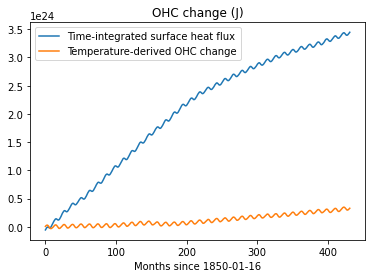

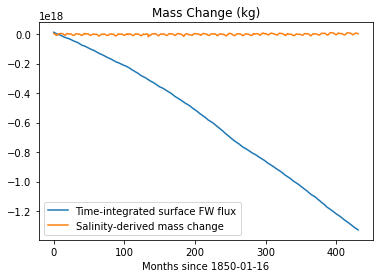

In [12]:
## Check for heat and salt closure
## HEAT
(((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time')-((ACCESS_BSP_data.hfds_sum*dt.average_DT).cumsum('Time').isel(Time=slice(0,12)).mean('Time'))).sum('Basin').sum('Depth').plot(label='Time-integrated surface heat flux')
((rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum))-(rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(0,12)).mean('Time'))).sum('Basin').sum('Depth').plot(label='Temperature-derived OHC change')
plt.title('OHC change (J)')
plt.xlabel('Months since 1850-01-16')
# plt.xlim(0,1980)

plt.legend()
# plt.savefig('../Figures/glob_hfds_OHC_closure.png', dpi=300, bbox_inches='tight')
plt.show()
## SALT
(((ACCESS_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time')-((ACCESS_BSP_data.wfo_sum*dt.average_DT).cumsum('Time').isel(Time=slice(0,12)).mean('Time'))).sum('Basin').sum('Depth').plot(label='Time-integrated surface FW flux')
((-ACCESS_BSP_data.S_mean/S0*rho*ACCESS_BSP_data.V_sum)-(-ACCESS_BSP_data.S_mean/S0*rho*ACCESS_BSP_data.V_sum).isel(Time=slice(0,12)).mean('Time')).sum('Basin').sum('Depth').plot(label='Salinity-derived mass change')
plt.title('Mass Change (kg)')
plt.xlabel('Months since 1850-01-16')
plt.legend()
# plt.xlim(0,1980)
# plt.savefig('../Figures/glob_wfo_OSC_closure.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Array defining the connection between the 9 basins;
# 1 = connected, 0 = disconnected
# connectivity_array = np.ones((Basins.size,Basins.size))

connectivity_array = np.zeros((Basins.size,Basins.size))

connectivity_array[0,:] = [1, 1, 0, 0, 0, 0, 0, 0, 0]
connectivity_array[1,:] = [1, 1, 1, 0, 0, 0, 0, 0, 0]
connectivity_array[2,:] = [0, 1, 1, 1, 0, 0, 0, 0, 0]
connectivity_array[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, 1]
connectivity_array[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, 1]
connectivity_array[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, 1]
connectivity_array[6,:] = [0, 0, 0, 0, 1, 1, 1, 1, 0]
connectivity_array[7,:] = [0, 0, 0, 0, 0, 0, 1, 1, 0]
connectivity_array[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

d = {Basins[0]: connectivity_array.T[0,:],\
    Basins[1]: connectivity_array.T[1,:],\
    Basins[2]: connectivity_array.T[2,:],\
    Basins[3]: connectivity_array.T[3,:],\
    Basins[4]: connectivity_array.T[4,:],\
    Basins[5]: connectivity_array.T[5,:],\
    Basins[6]: connectivity_array.T[6,:],\
    Basins[7]: connectivity_array.T[7,:],\
    Basins[8]: connectivity_array.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table

,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subtropical N. Atlantic,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
Indian,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
Eq. Pacific,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
N. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
Southern Ocean,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [14]:
# Array defining the transport between the 9 basins;
# +/-1 = connected (North = +, East = +), 0 = no constraint
transport_array = np.zeros((Basins.size,Basins.size))

transport_array[4,:] = [0, 0, 0, 0, 0, 0, 1, 0, 0]
transport_array[6,:] = [0, 0, 0, 0, -1, 0, 0, 0, 0]

d = {Basins[0]: transport_array.T[0,:],\
    Basins[1]: transport_array.T[1,:],\
    Basins[2]: transport_array.T[2,:],\
    Basins[3]: transport_array.T[3,:],\
    Basins[4]: transport_array.T[4,:],\
    Basins[5]: transport_array.T[5,:],\
    Basins[6]: transport_array.T[6,:],\
    Basins[7]: transport_array.T[7,:],\
    Basins[8]: transport_array.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table

,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subtropical N. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Indian,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Pacific,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
N. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Southern Ocean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Do the same for basin index
Basin_1 = np.zeros_like(V_shape)
Basin_2 = np.zeros_like(V_shape)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_shape.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

In [16]:
# Define whether a bin is connected to every other bin
# The two constraints used are: are the basins adjacent? 
# If yes, are the bin indices the same? 
# If yes, the bins are connected; if no, they are not connected. 

# connected = np.ones((Vol_1.size, Vol_1.size)) ## For all connections case

trans_big = np.zeros((V_shape.values.flatten().size, V_shape.values.flatten().size))
connected = np.zeros((V_shape.values.flatten().size, V_shape.values.flatten().size))

for i in tqdm(range(V_shape.values.flatten().size)):
    for j in range(V_shape.values.flatten().size):
        trans_big[i,j] = transport_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]
        if connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]>0:
            connected[i,j] = 1 ## For NO DOCKING case
            ## UNCOMMENT BELOW IF YOU WANT DOCKING AGAIN
                # if Basin_names[i] == Basin_names[j]:
                #     connected[i,j] = connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]
                # elif S_start[i]==S_start[j] and T_start[i]==T_start[j]:
                #     connected[i,j] = connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]

# constraints = connected # Shape: An [N x N] matrix

transport = trans_big  # Shape: An [N x N] matrix

  0%|          | 0/144 [00:00<?, ?it/s]

In [17]:
# Array defining the connection between the 9 basins;
# 1 = connected (sign convention: North = +, East = +), 0 = disconnected
d_ij = np.zeros((Basins.size,Basins.size))

d_ij[0,:] = [1, -1, 0, 0, 0, 0, 0, 0, 0]
d_ij[1,:] = [1, 1, -1, 0, 0, 0, 0, 0, 0]
d_ij[2,:] = [0, 1, 1, -1, 0, 0, 0, 0, 0]
d_ij[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, -1]
d_ij[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, -1]
d_ij[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, -1]
d_ij[6,:] = [0, 0, 0, 0, -1, -1, 1, 1, 0]
d_ij[7,:] = [0, 0, 0, 0, 0, 0, -1, 1, 0]
d_ij[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

basin_connex = np.array([[0,1],
                [1,2],
                [2,3],
                [3,8],
                [4,8],
                [4,6],
                [5,8],
                [6,5],
                [7,6]]).astype(int)


In [18]:
ACCESS_mapped_masks = xr.open_mfdataset('../Masks_processed/ACCESS_mask_%i_bins_7*.nc' %(tree_depth))

if tree_depth<=4:
    fuzz_combined = (ACCESS_mapped_masks.salt.isel(time=slice(108,216)).sum('time')/(9*12)).values
else:
    fuzz_combined = (ACCESS_mapped_masks.salt.sum('time')/(9*12)).values

mask_ACCESS_xr = xr.open_mfdataset('../Basin_mask/mask_ACCESS.nc')

mask_ACCESS = (mask_ACCESS_xr.mask_ACCESS.isel(st_ocean=0).values)

data_ACCESS_hfds = xr.open_mfdataset('~/UNSW_Work/ACCESS_CM2/hfds_ACCESS_hist_proper.nc') ## hfds: Wm^-2; wfo: kgm^-2s^-1

ACCESS_dArea = xr.open_mfdataset('~/UNSW_Work/ACCESS_CM2/darea_ACCESS_hist_proper.nc').sel(time=slice('1979-01-01',None)).mean('time')
ACCESS_dArea_masked = data_ACCESS_hfds.__xarray_dataarray_variable__.isel(time=0)/data_ACCESS_hfds.__xarray_dataarray_variable__.isel(time=0)*ACCESS_dArea.area_t

In [19]:
# Range of years over which 'early' and 'late' are defined
dyrs = np.array([9,9,9,5]) # size of early/late windows
tdiff = np.array([9,4,0,0]) # length of time either side of midpoint
year_mid = 1997

dOHC = np.zeros(dyrs.size)
dQ_prior = np.zeros(dyrs.size)
dQ_adj = np.zeros(dyrs.size)
dOSC = np.zeros(dyrs.size)
dQS_prior = np.zeros(dyrs.size)
dQS_adj = np.zeros(dyrs.size)

dQ_adj_basins = np.zeros((dyrs.size, V_shape.values.flatten().size))
dOHC_basins = np.zeros((dyrs.size, V_shape.values.flatten().size))
dQ_prior_basins = np.zeros((dyrs.size, V_shape.values.flatten().size))
dQS_adj_basins = np.zeros((dyrs.size, V_shape.values.flatten().size))
dOSC_basins = np.zeros((dyrs.size, V_shape.values.flatten().size))
dQS_prior_basins = np.zeros((dyrs.size, V_shape.values.flatten().size))

dQ_bias = np.zeros(dyrs.size)
dQS_bias = np.zeros(dyrs.size)
dQ_bias_basins = np.zeros((dyrs.size, V_shape.values.flatten().size))
dQS_bias_basins = np.zeros((dyrs.size, V_shape.values.flatten().size))

T_adj_array = np.zeros((dyrs.size, V_shape.values.flatten().size))
S_adj_array = np.zeros((dyrs.size, V_shape.values.flatten().size))

MSE_T = np.zeros(dyrs.size)
MSE_S = np.zeros(dyrs.size)
MSE_tot = np.zeros(dyrs.size)
opt_val = np.zeros(dyrs.size)

dhfds_adj_remapped_Wm2 = np.zeros((dyrs.size, ACCESS_dArea_masked.yt_ocean.size,ACCESS_dArea_masked.xt_ocean.size ))
dhfds_adj_remapped_J = np.zeros((dyrs.size,ACCESS_dArea_masked.yt_ocean.size, ACCESS_dArea_masked.xt_ocean.size))
dwfo_adj_remapped_mm_day = np.zeros((dyrs.size,ACCESS_dArea_masked.yt_ocean.size, ACCESS_dArea_masked.xt_ocean.size))
dwfo_adj_remapped_m3 = np.zeros((dyrs.size,ACCESS_dArea_masked.yt_ocean.size, ACCESS_dArea_masked.xt_ocean.size))

net_heat_trans_Basins = np.zeros((dyrs.size, Basins.size))
net_salt_trans_Basins = np.zeros((dyrs.size, Basins.size))

range_yrs = np.zeros(dyrs.size)


In [20]:
for time_step in tqdm(range(dyrs.size)):
    if ERA5 or tenpc_offset:
        year_start = year_mid-dyrs[time_step]-tdiff[time_step]
        year_end = year_mid+tdiff[time_step]
        range_yrs[time_step] = tdiff[time_step]*2+dyrs[time_step]
        Early_period = np.array([(year_start-1979)*12, (year_start+dyrs[time_step]-1979)*12-1])
        Late_period = np.array([(year_end-1979)*12, (year_end+dyrs[time_step]-1979)*12-1])
        Early_period_OG = np.array([(year_start-1850)*12, (year_start+dyrs[time_step]-1850)*12-1])
        Late_period_OG = np.array([(year_end-1850)*12, (year_end+dyrs[time_step]-1850)*12-1])
    else:
        year_start = year_mid-dyrs[time_step]-tdiff[time_step]
        year_end = year_mid+tdiff[time_step]
        range_yrs[time_step] = tdiff[time_step]*2+dyrs[time_step]
        Early_period = np.array([(year_start-1850)*12, (year_start+dyrs[time_step]-1850)*12-1])
        Late_period = np.array([(year_end-1850)*12, (year_end+dyrs[time_step]-1850)*12-1])

    ## Early Period
    Part_early = ACCESS_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
    SA_early =  ACCESS_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
    CT_early = (ACCESS_BSP_data.T_mean-273.15).isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
    V_early = ACCESS_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
    A_early = ACCESS_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
    CTV_early = ((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
    SAV_early = (ACCESS_BSP_data.S_mean*ACCESS_BSP_data.V_sum).isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])

    ## Late Period
    Part_late = ACCESS_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
    SA_late =  ACCESS_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
    CT_late = (ACCESS_BSP_data.T_mean-273.15).isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])-273.15
    V_late = ACCESS_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
    A_late = ACCESS_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
    CTV_late = ((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
    SAV_late = (ACCESS_BSP_data.S_mean*ACCESS_BSP_data.V_sum).isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])

    Basins = ACCESS_BSP_data.Basin.values

    int_scaling = ((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]+1))

    ## Convert Offset from W/m2 to W, and from mm/day to kg/s
    HF_offset_W = HF_offset*ACCESS_BSP_data.A_sum #W
    FW_offset_kg_s = FW_offset*ACCESS_BSP_data.A_sum*rho/(1000*24*3600) #kg/s
    if tenpc_offset:

        HFDS_Trenberth = (((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1]))\
        -(((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))\
             -((((ACCESS_BSP_OG.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period_OG[-1]))\
        -(((ACCESS_BSP_OG.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period_OG[0]))) # units: J
        WFO_Trenberth = ((ACCESS_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1])\
        -(((ACCESS_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg
        -((((ACCESS_BSP_OG.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period_OG[-1]))\
        -(((ACCESS_BSP_OG.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period_OG[0]))) # units: kg
        
        HF_offset_W = -HFDS_Trenberth.sum().values/(range_yrs[time_step]*yr2sec) #W
        FW_offset_kg_s = -WFO_Trenberth.sum().values/(range_yrs[time_step]*yr2sec) #kg/s

        HFDS_cumsum_bias = (((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1]))\
        -(((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))\
             -((((ACCESS_BSP_OG.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period_OG[-1]))\
        -(((ACCESS_BSP_OG.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period_OG[0]))) # units: J
        WFO_cumsum_bias = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1])\
        -(((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg
        -((((ACCESS_BSP_OG.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period_OG[-1]))\
        -(((ACCESS_BSP_OG.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period_OG[0]))) # units: kg

        dhfds_bias = HFDS_cumsum_bias*int_scaling
        dwfo_bias = WFO_cumsum_bias*int_scaling
        
        dT_bias = (dhfds_bias/(Cp*rho*V_early)).values.flatten() # units: C
        dS_bias = (-dwfo_bias*S0/(rho*V_early)).values.flatten() # units: g/kg

    elif ERA5: 
        
        HFDS_cumsum_bias = (((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1]))\
        -(((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))\
             -((((ACCESS_BSP_OG.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period_OG[-1]))\
        -(((ACCESS_BSP_OG.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period_OG[0]))) # units: J
        WFO_cumsum_bias = ((ACCESS_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1])\
        -(((ACCESS_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg
        -((((ACCESS_BSP_OG.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period_OG[-1]))\
        -(((ACCESS_BSP_OG.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period_OG[0]))) # units: kg

        dhfds_bias = HFDS_cumsum_bias*int_scaling
        dwfo_bias = WFO_cumsum_bias*int_scaling
        
        dT_bias = (dhfds_bias/(Cp*rho*V_early)).values.flatten() # units: C
        dS_bias = (-dwfo_bias*S0/(rho*V_early)).values.flatten() # units: g/kg

    else:
        HFDS_cumsum_bias = (((HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1]))\
        -(((HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0])) # units: J
        WFO_cumsum_bias = ((FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1])\
        -(((FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg
        
        dhfds_bias = HFDS_cumsum_bias*int_scaling
        dwfo_bias = WFO_cumsum_bias*int_scaling
        
        dT_bias = (dhfds_bias/(Cp*rho*V_early)).values.flatten() # units: C
        dS_bias = (-dwfo_bias*S0/(rho*V_early)).values.flatten() # units: g/kg

    ## Load Q_prior data here
    if SF:
        ## Calculate the cumulative time integrated surface fluxes 
        HFDS_cumsum = (((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1]))\
            -(((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0])) # units: J
        WFO_cumsum = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1])\
            -(((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg

        ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
        dhfds = HFDS_cumsum*int_scaling
        dwfo = WFO_cumsum*int_scaling

        ## Convert dflux to equivalent T or S change
        dT_prior = (dhfds/(Cp*rho*V_early)).values.flatten() # units: C
        dS_prior = (-dwfo*S0/(rho*V_early)).values.flatten() # units: g/kg

        time = ACCESS_BSP_data.Time.values
    else:
        dT_prior = np.zeros_like(ACCESS_BSP_data.hfds_sum.isel(Time=0).values.flatten())
        dS_prior = np.zeros_like(ACCESS_BSP_data.hfds_sum.isel(Time=0).values.flatten())

    # Flatten the early and late variables to a 1D array
    Vol_1 = V_early.values.flatten()
    Vol_2 = V_late.values.flatten()
    S_1 = SAV_early.values.flatten()/Vol_1-S0 # Remove reference salinity S0
    S_2 = SAV_late.values.flatten()/Vol_2-S0 # Remove reference salinity S0
    T_1 = CTV_early.values.flatten()/Vol_1
    T_2 = CTV_late.values.flatten()/Vol_2
    A_1 = A_early.values.flatten()
    A_2 = A_late.values.flatten()

    # Any NaNs are zeroed out
    S_1[np.isnan(S_1)] = 0
    S_2[np.isnan(S_2)] = 0
    T_1[np.isnan(T_1)] = 0
    T_2[np.isnan(T_2)] = 0

    ##Scale by a small amount
    Vol_2_star = Vol_1 + (Vol_2 - Vol_1)
    T_2_star = (CTV_early.values.flatten()+\
            (CTV_late.values.flatten()-CTV_early.values.flatten()))/Vol_2_star
    S_2_star = (SAV_early.values.flatten()+\
            (SAV_late.values.flatten()-SAV_early.values.flatten()))/Vol_2_star-S0
    A_2_star = A_1 + (A_2 - A_1)

    # Any NaNs are zeroed out
    S_2_star[np.isnan(S_2_star)] = 0
    T_2_star[np.isnan(T_2_star)] = 0

    #... and for the edges of the BSP bins
    ## Here we calculate the mean TS edges averaged over both early and late times
    S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
    S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
    T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
    T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

    if SF: 
        ## Add the Q_prior to S_0; T_0 to get the 'initial' state ##
        S_pre = SAV_early.values.flatten()/Vol_1-S0
        S_1 = SAV_early.values.flatten()/Vol_1-S0+dS_prior
        T_pre = CTV_early.values.flatten()/Vol_1
        T_1 = CTV_early.values.flatten()/Vol_1+dT_prior
        S_1[np.isnan(S_1)] = 0
        T_1[np.isnan(T_1)] = 0
        S_1[~np.isfinite(S_1)] = 0
        T_1[~np.isfinite(T_1)] = 0
        S_pre[np.isnan(S_pre)] = 0
        T_pre[np.isnan(T_pre)] = 0
        S_pre[~np.isfinite(S_pre)] = 0
        T_pre[~np.isfinite(T_pre)] = 0

    volumes = np.stack((Vol_1, Vol_2_star), axis=0)/volnorming # Shape: [2 x N]

    salinities = np.stack((S_1, S_2_star), axis=0)
    temps = np.stack((T_1, T_2_star), axis=0)

    tracers = np.stack((salinities, temps),axis=1) # Shape: [2 x M x N], where M = 2 for just T and S, and M>2 for T,S+other tracers

    ## We create a weight matrix
    # For sqrt(1/Area)
    A_2_modified = A_2_star.copy()

    A_2_modified[A_2_modified==0] = 1.3*np.nanmin(A_2_star[A_2_star>0]) # this is the lowest I can make it for tree_depth=4 without it breaking

    area_weight = np.sqrt(areanorming/A_2_modified)

    area_cons = A_2_star/A_2_star-1
    area_cons[np.isnan(area_cons)] = 1

    weights = np.stack((S_scale*area_weight, T_scale*area_weight), axis=0) # Shape: An [M x N] matrix
    hard_area = np.stack((area_cons,area_cons), axis=0)

    ## Function has form MTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = constraints, 
    #                                 trans = [transport,trans_val], Asection = [connected_Asection,threshold], weights=weights, hard_area = hard_area)
    if SF:
        result = MTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = connected, weights=weights)#, hard_area = hard_area)
    else:
        result = MTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = connected, weights=weights)

    g_ij = result['g_ij'] ## An [N x N] matrix of transports between WMs
    Mixing = result['Mixing'] ## An [M x N] matrix of dtracer mixing for each WM
    Adjustment = result['Adjustment'] ## An [M x N] matrix of dtracer adjustment for each WM
    G = result['G'] ## An [ix] matrix of transports between WMs

    N = int(Vol_1.shape[0])

    dT_mixing = Mixing[1,:]
    dS_mixing = Mixing[0,:]
    dS_adj = Adjustment[0,:]
    dT_adj = Adjustment[1,:]


    ########
    nofaces = np.count_nonzero(connected)


    G = np.zeros((int(nofaces)))
    ix=0
    for i in (range(N)):
        for j in range(N):
            if connected[i,j]>0:
                G[ix] = g_ij[i,j]
                ix=ix+1   


    Tmatrix=np.zeros((N,int(nofaces)))
    Smatrix=np.zeros((N,int(nofaces)))

    ix=0
    for i in (range(N)):
        for j in range(N):
            if connected[i,j]>0:
                Tmatrix[j,ix] = tracers[0,1,i] #vertex ix brings temp of WM i to WM j
                Smatrix[j,ix] = tracers[0,0,i] #vertex ix brings temp of WM i to WM j

                ix=ix+1

    dTV = (volumes[1,:]*T_2_star)-(volumes[0,:]*T_pre)
    dTVprior = dT_prior*volumes[0,:]
    dTVbias = dT_bias*volumes[0,:]
    T1V1 = volumes[1,:]*T_2_star

    dSV = (volumes[1,:]*S_2_star)-(volumes[0,:]*S_pre)
    dSVprior = dS_prior*volumes[0,:]
    dSVbias = dS_bias*volumes[0,:]
    S1V1 = volumes[1,:]*S_2_star

    test = ((Tmatrix@G/volumes[1,:]))
    testS = ((Smatrix@G/volumes[1,:]))
    test[~np.isfinite(test)]= np.nan
    test[test>100] = np.nan
    testS[~np.isfinite(testS)]= np.nan
    testS[testS>100] = np.nan

    test2  = T_2_star - test
    test2[np.isnan(test2)] = 0
    test2S  = S_2_star - testS
    test2S[np.isnan(test2S)] = 0

    T_adj_array[time_step,:] = test2
    S_adj_array[time_step,:] = test2S
  
    # Tmatrix = (T0+dT_prior)
    # dT_prior = dT_actual+dT_bias

    # dT_adj, dT_bias, (dOHC-MHT-dT_prior+dT_bias)
    # dOHC = T1V1-T0V0
    # MHT = (gij*(T0+dT_prior))
    # MHT_nobias = (gij*(T0+dT_prior-dT_bias))

    # dT_adj = dOHC-MHT-dT_actual

    dQ_adj[time_step] = np.nansum((T1V1-Tmatrix@G))
    dOHC[time_step] = np.nansum(dTV)
    dQ_prior[time_step] = np.nansum(dTVprior)
    dQ_bias[time_step] = np.nansum(dTVbias)

    dQS_adj[time_step] = np.nansum(S1V1-Smatrix@G)
    dOSC[time_step] = np.nansum(dSV)
    dQS_prior[time_step] = np.nansum(dSVprior)
    dQS_bias[time_step] = np.nansum(dSVbias)

    dQ_adj_basins[time_step,:] = ((T1V1-Tmatrix@G))
    dOHC_basins[time_step,:] = (dTV)
    dQ_prior_basins[time_step,:] = (dTVprior)
    dQ_bias_basins[time_step,:] = (dTVbias)

    dQS_adj_basins[time_step,:] = (S1V1-Smatrix@G)
    dOSC_basins[time_step,:] = (dSV)
    dQS_prior_basins[time_step,:] = (dSVprior)
    dQS_bias_basins[time_step,:] = (dSVbias)

    A_T = np.zeros_like(Tmatrix)
    A_S = np.zeros_like(Tmatrix)

    for i in range(int(nofaces)):
        A_T[:,i] = Tmatrix[:,i]*weights[1,:]
        A_S[:,i] = Smatrix[:,i]*weights[0,:]

    A = np.concatenate((A_T,A_S),axis=0)
    
    b = np.concatenate((volumes[1,:]*tracers[1,1,:]*weights[1,:],\
                    volumes[1,:]*tracers[1,0,:]*weights[0,:]), axis=0)
    b[np.isnan(b)]=0

    MSE_T[time_step] = np.nansum(abs(-T1V1*weights[1,:]+(A_T)@G)**2)
    MSE_S[time_step] = np.nansum(abs(-S1V1*weights[0,:]+(A_S)@G)**2)
    MSE_tot[time_step] = np.nansum(abs(A@G-b)**2)

    dS_adj_stacked = S_adj_array[time_step,:]
    dT_adj_stacked = T_adj_array[time_step,:]

    Vol_2_star_da = xr.DataArray(data = Vol_2_star, dims ={'WM_number'}, coords = {'WM_number':np.arange(0,144)})
    A_2_star_da = xr.DataArray(data = A_2_star, dims ={'WM_number'}, coords = {'WM_number':np.arange(0,144)})

    ds_vol_late_stacked = Vol_2_star_da
    ds_area_late_stacked = A_2_star_da
    ds_area_early_stacked = A_early.stack(WM_number = ['Basin', 'Depth'])
    ds_area_early_stacked['WM_number'] = np.arange(0,144)

    mask_WM_basin = mask_ACCESS_xr.mask_ACCESS.isel(st_ocean=0)*(ACCESS_mapped_masks.salt.isel(time=slice(108,216)).sum('time')/(9*12))
    mask_WM_basin_stacked = mask_WM_basin.stack(WM_number = ['Basins', 'tree_depth'])
    mask_WM_basin_stacked['WM_number'] = np.arange(0,144)

    ### Adjustment in W/m2 for maps
    dhfds_adj_Wm2 = dT_adj_stacked*ds_vol_late_stacked*rho*Cp/(range_yrs[time_step]*yr2sec*ds_area_late_stacked)
    dhfds_adj_remapped_Wm2_bias = (dhfds_adj_Wm2.where(abs(dhfds_adj_Wm2)!=np.inf, 0)*mask_WM_basin_stacked).sum('WM_number')

    ## Adjustment in J for the heat budget
    dhfds_adj_J = dT_adj_stacked*ds_vol_late_stacked*rho*Cp/ds_area_late_stacked

    dhfds_adj_remapped_J_bias = (dhfds_adj_J.where(abs(dhfds_adj_J)!=np.inf, 0)*mask_WM_basin_stacked).sum('WM_number')*ACCESS_dArea_masked

    dhfds_adj_J_missing = ((dT_adj_stacked*ds_vol_late_stacked*rho*Cp).sum('WM_number')-\
                                    (dhfds_adj_remapped_J_bias).sum(['xt_ocean','yt_ocean']))

    dhfds_adj_remapped_Wm2_missing = dhfds_adj_J_missing/(range_yrs[time_step]*yr2sec*np.nansum(ACCESS_dArea_masked.values))
    dhfds_adj_remapped_Wm2[time_step,:,:] = dhfds_adj_remapped_Wm2_bias+dhfds_adj_remapped_Wm2_missing
    dhfds_adj_remapped_J[time_step,:,:] = dhfds_adj_remapped_J_bias+dhfds_adj_J_missing/(np.nansum(ACCESS_dArea_masked.values))*ACCESS_dArea_masked

    dwfo_adj_mm_day = -dS_adj_stacked*ds_vol_late_stacked/(range_yrs[time_step]*yr2sec*ds_area_late_stacked*S0)*24*3600*1000
    dwfo_adj_remapped_mm_day_bias = (dwfo_adj_mm_day.where(abs(dwfo_adj_mm_day)!=np.inf, 0)*mask_WM_basin_stacked).sum('WM_number')

    ## Adjustment in m3 for the FW budget
    dwfo_adj_m3 = -dS_adj_stacked*ds_vol_late_stacked/(S0*ds_area_late_stacked)
    dwfo_adj_remapped_m3_bias = (dwfo_adj_m3.where(abs(dwfo_adj_m3)!=np.inf, 0).fillna(0)*mask_WM_basin_stacked).sum('WM_number')*ACCESS_dArea_masked

    dwfo_adj_m3_missing = ((-dS_adj_stacked*ds_vol_late_stacked/S0).sum('WM_number')-\
                                    (dwfo_adj_remapped_m3_bias).sum(['xt_ocean','yt_ocean']))

    dwfo_adj_remapped_mm_day_missing = dwfo_adj_m3_missing/(range_yrs[time_step]*yr2sec*np.nansum(ACCESS_dArea_masked.values))*24*3600*1000
    dwfo_adj_remapped_mm_day[time_step,:,:] = dwfo_adj_remapped_mm_day_bias+dwfo_adj_remapped_mm_day_missing
    dwfo_adj_remapped_m3[time_step,:,:] = dwfo_adj_remapped_m3_bias+dwfo_adj_m3_missing/(np.nansum(ACCESS_dArea_masked.values))*ACCESS_dArea_masked


    section_trans = np.zeros((Vol_1.size,Vol_1.size))
    for i in (range(Vol_1.size)):
        for j in range(Vol_2.size):
            if d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
                if Basin_names[i] != Basin_names[j]:
                    section_trans[i,j] = g_ij[i,j]*d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])] #m3

    section_trans_temp = np.zeros((Vol_1.size, Basins.size))
    for j in range(Basins.size):
        section_trans_temp[:,j] = np.nansum(section_trans[:,V_early.shape[1]*j:(V_early.shape[1]*(j+1))],axis=-1)

    T_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
    S_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
    section_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))

    for i in range(int(np.size(basin_connex)/2)):
        T_joined[i,:] = np.concatenate([T_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],T_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
        S_joined[i,:] = np.concatenate([S_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],S_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
        section_joined[i,:] = np.concatenate([section_trans_temp[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1)),basin_connex[i][1]],\
            section_trans_temp[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1)),basin_connex[i][0]]])

    heat_trans = T_joined*section_joined*rho*Cp*volnorming #J
    HF_section_tot = np.nansum(heat_trans, axis=-1)
    salt_trans = S_joined/S0*section_joined*volnorming # m3
    FWF_section_tot = np.nansum(salt_trans, axis=-1)

    net_heat_trans_Basins[time_step,:] = [HF_section_tot[0],\
        HF_section_tot[1]-HF_section_tot[0],\
            HF_section_tot[2]-HF_section_tot[1],\
                HF_section_tot[3]-HF_section_tot[2],\
                    HF_section_tot[4]-HF_section_tot[5],\
                        HF_section_tot[6]-HF_section_tot[7],\
                            HF_section_tot[7]-HF_section_tot[8]+HF_section_tot[5],\
                                HF_section_tot[8],\
                                -HF_section_tot[4]-HF_section_tot[6]-HF_section_tot[3]]

    net_salt_trans_Basins[time_step,:] = [FWF_section_tot[0],\
        FWF_section_tot[1]-FWF_section_tot[0],\
            FWF_section_tot[2]-FWF_section_tot[1],\
                FWF_section_tot[3]-FWF_section_tot[2],\
                    FWF_section_tot[4]-FWF_section_tot[5],\
                        FWF_section_tot[6]-FWF_section_tot[7],\
                            FWF_section_tot[7]-FWF_section_tot[8]+FWF_section_tot[5],\
                                FWF_section_tot[8],\
                                -FWF_section_tot[4]-FWF_section_tot[6]-FWF_section_tot[3]]


  0%|          | 0/4 [00:00<?, ?it/s]

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) May 07 02:35:02 PM: Your problem has 6912 variables, 2 constraints, and 0 parameters.
(CVXPY) May 07 02:35:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 07 02:35:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 07 02:35:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 07 02:35:02 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 07 02:35:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

In [166]:
net_heat_trans_Basins

array([[ 4.57185893e+23,  1.47540345e+23, -3.90240809e+23,
        -3.57088768e+22,  1.49747905e+23,  7.51793039e+22,
        -1.26346606e+24,  4.48070113e+23,  4.11692190e+23],
       [ 2.76114498e+23,  5.62375942e+22, -2.44779550e+23,
        -1.72869152e+22,  1.23715293e+23,  4.50635172e+22,
        -7.94857410e+23,  2.77285661e+23,  2.78507311e+23],
       [ 1.49053610e+23,  2.17437512e+21, -1.25544782e+23,
        -2.64938688e+21,  7.51496842e+22,  1.80546574e+22,
        -4.22673629e+23,  1.52454841e+23,  1.53980630e+23],
       [ 8.43038714e+22, -6.87350063e+21, -6.50445728e+22,
         5.66592773e+21,  3.92549175e+22,  1.01097107e+22,
        -2.37639651e+23,  7.90817666e+22,  9.11415305e+22]])

In [159]:
HFDS_Trenberth = ((((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1]))\
-(((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0])))\
     -((((ACCESS_BSP_OG.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period_OG[-1]))\
-(((ACCESS_BSP_OG.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period_OG[0]))) # units: J
WFO_Trenberth = (((ACCESS_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1])\
-(((ACCESS_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0])))# units: kg
-((((ACCESS_BSP_OG.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period_OG[-1]))\
-(((ACCESS_BSP_OG.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period_OG[0]))) # units: kg

HF_offset_W = -HFDS_Trenberth.sum().values/\
     (dt.average_DT.isel(Time=slice(Early_period[0], Late_period[-1])).sum().values\
          *ACCESS_BSP_data.A_sum.sum().values)*ACCESS_BSP_data.A_sum #W
FW_offset_kg_s = -WFO_Trenberth.sum().values/\
     (dt.average_DT.isel(Time=slice(Early_period[0], Late_period[-1])).sum().values\
          *ACCESS_BSP_data.A_sum.sum().values)*ACCESS_BSP_data.A_sum #kg/s

HFDS_cumsum_bias = (((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1]))\
-(((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))\
     -((((ACCESS_BSP_OG.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period_OG[-1]))\
-(((ACCESS_BSP_OG.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period_OG[0]))) # units: J
WFO_cumsum_bias = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1])\
-(((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg
-((((ACCESS_BSP_OG.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period_OG[-1]))\
-(((ACCESS_BSP_OG.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period_OG[0]))) # units: kg

dhfds_bias = HFDS_cumsum_bias*int_scaling
dwfo_bias = WFO_cumsum_bias*int_scaling

dT_bias = (dhfds_bias/(Cp*rho*V_early)).values.flatten() # units: C
dS_bias = (-dwfo_bias*S0/(rho*V_early)).values.flatten() # units: g/kg

HFDS_cumsum = (((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1]))\
     -(((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0])) # units: J
WFO_cumsum = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1])\
     -(((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg

## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
dhfds = HFDS_cumsum*int_scaling
dwfo = WFO_cumsum*int_scaling

## Convert dflux to equivalent T or S change
dT_prior = (dhfds/(Cp*rho*V_early)).values.flatten() # units: C
dS_prior = (-dwfo*S0/(rho*V_early)).values.flatten() # units: g/kg

time = ACCESS_BSP_data.Time.values

HFDS_cumsum_OG = ((((ACCESS_BSP_OG.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period_OG[-1]))\
-(((ACCESS_BSP_OG.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period_OG[0]))) # units: J

HFDS_cumsum_ERA5 = ((((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1]))\
-(((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))) # units: J


In [160]:
print((dt.average_DT.isel(Time=slice(Early_period[0], Late_period[-1])).sum().values)/1e9)
print((1979-2015)*yr2sec/1e9)

0.3129408
-1.1360736


In [161]:
(HFDS_Trenberth.sum().values)

array(9.06804404e+23)

In [162]:
HF_offset_W.sum().values/1e15 # should be around 2.2e13

-2.897686732578601

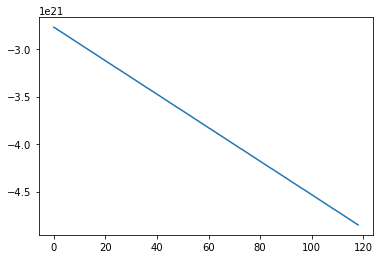

In [165]:
plt.plot((HF_offset_W*dt.average_DT).sum(['Basin','Depth']).cumsum('Time').isel(Time=slice(Early_period[0], Late_period[-1])).values)

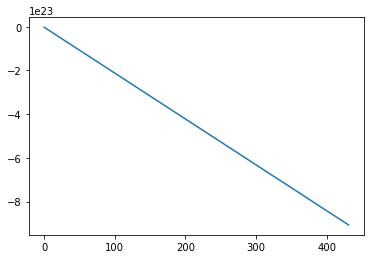

In [158]:
plt.plot((HF_offset_W*dt.average_DT).sum(['Basin','Depth']).cumsum('Time').values)
# plt.plot(((ACCESS_BSP_data.hfds_sum-2.2e13)*dt.average_DT).sum(['Basin','Depth']).cumsum('Time').isel(Time=slice(Early_period[0],Late_period[-1])).values)
# plt.plot(((ACCESS_BSP_OG.hfds_sum)*dt.average_DT).sum(['Basin','Depth']).cumsum('Time').isel(Time=slice(Early_period_OG[0],Late_period_OG[-1])).values)

In [63]:
print(dhfds.sum().values/int_scaling)
print(dhfds_bias.sum().values/int_scaling)
print(HFDS_cumsum_OG.sum().values)
print(HFDS_cumsum_ERA5.sum().values)
print(HFDS_Trenberth.sum().values)


9.822530515380094e+23
9.026412922794357e+23
7.961175925857355e+22
9.86416163501107e+23
9.068044042425334e+23


In [56]:
HF_offset_W

174154506685467.4

In [52]:
print((HFDS_Trenberth)/())
print((HFDS_cumsum_OG).sum().values)
print((HFDS_cumsum_ERA5).sum().values)

ValueError: operands could not be broadcast together with shapes (9, 16) (0,)

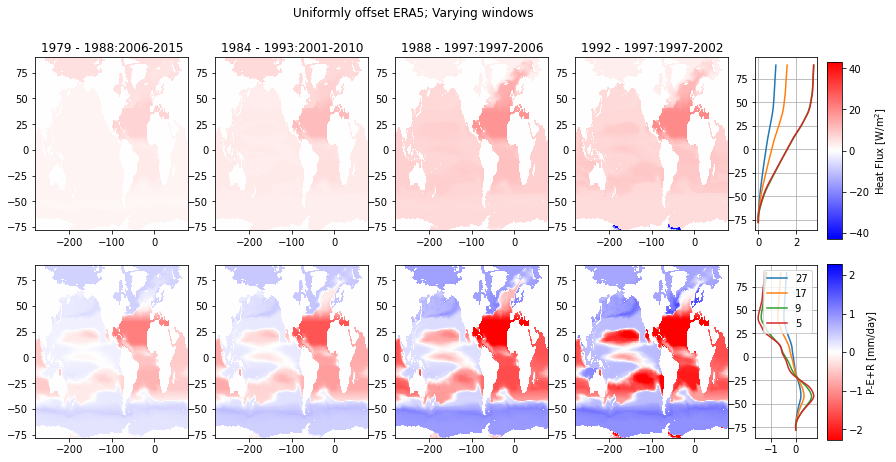

In [21]:
fig, axs = plt.subplots(2,5, figsize=(20*0.7,10*0.7), facecolor='w', edgecolor='k', gridspec_kw={'width_ratios':[1,1,1,1,0.4]})
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel()

# Known Q_prior
minvT, maxvT = -1,1
minvS, maxvS = -0.01, 0.01
## Known constant_offset
# minvT, maxvT = -abs(HF_offset)-10,abs(HF_offset)+10
# minvS, maxvS = -abs(FW_offset)-1,abs(FW_offset)+1
## Known bias
# scale = 1/3.5
# minvT, maxvT = -150*scale, 150*scale
# minvS, maxvS = -8*scale, 8*scale
# Known Trenberth
scale = 1/3.5
minvT, maxvT = -150*scale, 150*scale
minvS, maxvS = -8*scale, 8*scale

for i in range(dyrs.size):
    axs[i].set_title(str(int(year_mid-dyrs[i]-tdiff[i]))+' - '+str(int(year_mid-tdiff[i]))+':'+\
                    str(int(year_mid+tdiff[i]))+'-'+str(int(year_mid+tdiff[i]+dyrs[i])))
    axs[i].pcolor(ACCESS_dArea.xt_ocean,ACCESS_dArea.yt_ocean, dhfds_adj_remapped_Wm2[i,:,:], vmin=minvT, vmax=maxvT, cmap=plt.cm.bwr)
    axs[4].plot((np.cumsum(np.nansum(dhfds_adj_remapped_J[i,:,:],axis=-1),axis=-1)/(range_yrs[i]*yr2sec*1e15)), ACCESS_dArea.yt_ocean, label = str(tdiff[i]*2+dyrs[i]))
    axs[i+5].pcolor(ACCESS_dArea.xt_ocean,ACCESS_dArea.yt_ocean,dwfo_adj_remapped_mm_day[i,:,:], vmin=minvS, vmax=maxvS, cmap=plt.cm.bwr_r)
    axs[9].plot(np.cumsum(np.nansum(dwfo_adj_remapped_m3[i,:,:], axis=-1), axis=-1)/(range_yrs[i]*yr2sec*1e6), ACCESS_dArea.yt_ocean, label = str(tdiff[i]*2+dyrs[i]))
axs[9].legend()
axs[4].grid()
axs[9].grid()

cax = fig.add_axes([0.91, 0.52, 0.015, 0.35])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minvT, maxvT)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Heat Flux [W/m$^2$]')

cax = fig.add_axes([0.91, 0.12, 0.015, 0.35])
m = plt.cm.ScalarMappable(cmap='bwr_r')
m.set_clim(minvS, maxvS)
cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
cbar.set_label('P-E+R [mm/day]')
plt.suptitle('Uniformly offset ERA5; Varying windows')
# plt.savefig('../Figures/ACCESS_varying_windows_known_Q_prior.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
print(dOHC*volnorming*rho*Cp)
print(dQ_prior*volnorming*rho*Cp)
print(dQ_adj*volnorming*rho*Cp)
print(dQ_bias*volnorming*rho*Cp)
print(np.nansum(net_heat_trans_Basins,axis=-1))
print('##########')
print(dQS_adj*volnorming)
print(dOSC*volnorming)
print(dQS_prior*volnorming)
print(dQS_bias*volnorming*rho*Cp)
print(np.nansum(net_salt_trans_Basins,axis=-1))



[2.46223041e+23 1.55193152e+23 8.67408598e+22 5.78727216e+22]
[-5.47239418e+23 -6.67201340e+23 -7.45898016e+23 -4.06024102e+23]
[7.93462713e+23 8.22394575e+23 8.32639132e+23 4.63896999e+23]
[-7.87541823e+23 -8.13036183e+23 -8.22872472e+23 -4.45829982e+23]
[0. 0. 0. 0.]
##########
[1.11564146e+16 1.14132832e+16 1.17717418e+16 6.86155911e+15]
[-7.45296893e+13 -5.70357142e+13 -5.09261398e+13 -3.72859748e+13]
[-1.12309476e+16 -1.14703198e+16 -1.18226700e+16 -6.89884752e+15]
[-4.64043309e+22 -4.73933751e+22 -4.88492251e+22 -2.85048433e+22]
[ 0.015625    0.0078125  -0.015625   -0.01171875]


In [75]:
basin_scale_OHC = np.nansum(dOHC_basins.reshape(dyrs.size,9,16), axis=-1)*rho*Cp*volnorming
basin_scale_MHT = net_heat_trans_Basins
basin_scale_Q_prior = np.nansum(dQ_prior_basins.reshape(dyrs.size,9,16), axis=-1)*rho*Cp*volnorming
basin_scale_Q_bias = np.nansum(dQ_bias_basins.reshape(dyrs.size,9,16), axis=-1)*rho*Cp*volnorming
basin_scale_Q_adj = np.nansum(dQ_adj_basins.reshape(dyrs.size,9,16), axis=-1)*rho*Cp*volnorming
basin_scale_OSC = -np.nansum(dOSC_basins.reshape(dyrs.size,9,16), axis=-1)/S0*volnorming
basin_scale_QS_prior = -np.nansum(dQS_prior_basins.reshape(dyrs.size,9,16), axis=-1)/S0*volnorming
basin_scale_QS_bias = -np.nansum(dQS_bias_basins.reshape(dyrs.size,9,16), axis=-1)/S0*volnorming
basin_scale_QS_adj = -np.nansum(dQS_adj_basins.reshape(dyrs.size,9,16), axis=-1)/S0*volnorming
basin_scale_MST = net_salt_trans_Basins
basin_scale_residual_HF = -basin_scale_OHC+basin_scale_MHT+basin_scale_Q_prior+basin_scale_Q_adj
basin_scale_residual_FW = -basin_scale_OSC-basin_scale_MST+basin_scale_QS_prior+basin_scale_QS_adj
basin_scale_nonclosure_HF = -basin_scale_OHC+basin_scale_MHT+basin_scale_Q_prior-basin_scale_Q_bias
basin_scale_nonclosure_FW = -basin_scale_OSC-basin_scale_MST+basin_scale_QS_prior-basin_scale_Q_bias

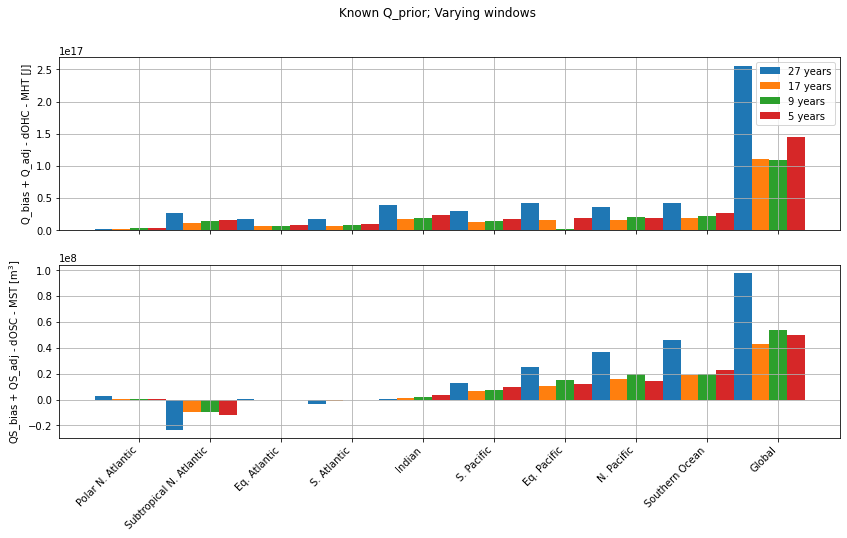

In [76]:

labels = np.append(CT_early.Basin.values, 'Global')
x = np.arange(len(labels))+0.5  # the label locations
width = 0.25  # the width of the bars

fig, axs = plt.subplots(2,1, figsize=(20*0.7,10*0.7), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel()
# for i in range(dyrs.size):

axs[0].bar(x-width*2, np.append(basin_scale_residual_HF[0,:], np.nansum(basin_scale_residual_HF, axis=-1)[0]), width, label = '27 years')
axs[0].bar(x-width, np.append(basin_scale_residual_HF[1,:], np.nansum(basin_scale_residual_HF, axis=-1)[1]), width, label = '17 years')
axs[0].bar(x, np.append(basin_scale_residual_HF[2,:], np.nansum(basin_scale_residual_HF, axis=-1)[2]), width, label = '9 years')
axs[0].bar(x+width, np.append(basin_scale_residual_HF[3,:], np.nansum(basin_scale_residual_HF, axis=-1)[3]), width, label = '5 years')

axs[1].bar(x-width*2, np.append(basin_scale_residual_FW[0,:], np.nansum(basin_scale_residual_FW, axis=-1)[0]), width, label = '27')
axs[1].bar(x-width, np.append(basin_scale_residual_FW[1,:], np.nansum(basin_scale_residual_FW, axis=-1)[1]), width, label = '27')
axs[1].bar(x, np.append(basin_scale_residual_FW[2,:], np.nansum(basin_scale_residual_FW, axis=-1)[2]), width, label = '27')
axs[1].bar(x+width, np.append(basin_scale_residual_FW[3,:], np.nansum(basin_scale_residual_FW, axis=-1)[3]), width, label = '27')

axs[0].set_xticks(x)
# axs[0].set_xlim(0.25, 9.75)
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, rotation=45, ha='right')
axs[0].set_xticklabels([])
axs[0].grid()
axs[1].grid()

axs[0].set_ylabel('Q_bias + Q_adj - dOHC - MHT [J]')
axs[1].set_ylabel('QS_bias + QS_adj - dOSC - MST [m$^3$]')

plt.suptitle('Known Q_prior; Varying windows')
axs[0].legend()
plt.savefig('../Figures/ACCESS_varying_windows_known_Q_prior_bars.png', dpi=300, bbox_inches='tight')
plt.show()
    



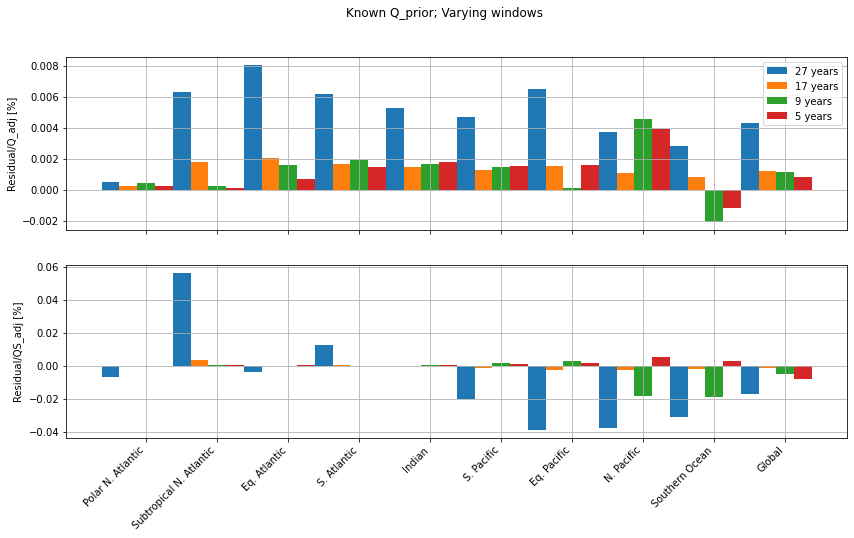

In [77]:

labels = np.append(CT_early.Basin.values, 'Global')
x = np.arange(len(labels))+0.5  # the label locations
width = 0.25  # the width of the bars

fig, axs = plt.subplots(2,1, figsize=(20*0.7,10*0.7), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel()
# for i in range(dyrs.size):

axs[0].bar(x-width*2, np.append(basin_scale_residual_HF[0,:], np.nansum(basin_scale_residual_HF, axis=-1)[0])/\
    np.append((basin_scale_Q_adj)[0,:], np.nansum((basin_scale_Q_adj), axis=-1)[0])*100, width, label = '27 years')
axs[0].bar(x-width, np.append(basin_scale_residual_HF[1,:], np.nansum(basin_scale_residual_HF, axis=-1)[1])/\
    np.append((basin_scale_Q_adj)[1,:], np.nansum((basin_scale_Q_adj), axis=-1)[1])*100, width, label = '17 years')
axs[0].bar(x, np.append(basin_scale_residual_HF[2,:], np.nansum(basin_scale_residual_HF, axis=-1)[2])/\
    np.append((basin_scale_Q_adj)[2,:], np.nansum((basin_scale_Q_adj), axis=-1)[2])*100, width, label = '9 years')
axs[0].bar(x+width, np.append(basin_scale_residual_HF[3,:], np.nansum(basin_scale_residual_HF, axis=-1)[3])/\
    np.append((basin_scale_Q_adj)[3,:], np.nansum((basin_scale_Q_adj), axis=-1)[3])*100, width, label = '5 years')

axs[1].bar(x-width*2, np.append(basin_scale_residual_FW[0,:], np.nansum(basin_scale_residual_FW, axis=-1)[0])/\
    np.append((basin_scale_QS_adj)[0,:], np.nansum((basin_scale_QS_adj), axis=-1)[0])*100, width, label = '27 years')
axs[1].bar(x-width, np.append(basin_scale_residual_FW[1,:], np.nansum(basin_scale_residual_FW, axis=-1)[1])/\
    np.append((basin_scale_QS_adj)[1,:], np.nansum((basin_scale_QS_adj), axis=-1)[1])*100, width, label = '17 years')
axs[1].bar(x, np.append(basin_scale_residual_FW[2,:], np.nansum(basin_scale_residual_FW, axis=-1)[2])/\
    np.append((basin_scale_QS_adj)[2,:], np.nansum((basin_scale_QS_adj), axis=-1)[2])*100, width, label = '9 years')
axs[1].bar(x+width, np.append(basin_scale_residual_FW[3,:], np.nansum(basin_scale_residual_FW, axis=-1)[3])/\
    np.append((basin_scale_QS_adj)[3,:], np.nansum((basin_scale_QS_adj), axis=-1)[3])*100, width, label = '5 years')

axs[0].set_xticks(x)
# axs[0].set_xlim(0.25, 9.75)
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, rotation=45, ha='right')
axs[0].set_xticklabels([])
axs[0].grid()
axs[1].grid()

axs[0].set_ylabel('Residual/Q_adj [%]')
axs[1].set_ylabel('Residual/QS_adj [%]')

plt.suptitle('Known Q_prior; Varying windows')
axs[0].legend()
plt.savefig('../Figures/ACCESS_varying_windows_known_Q_prior_bars_perc.png', dpi=300, bbox_inches='tight')
plt.show()

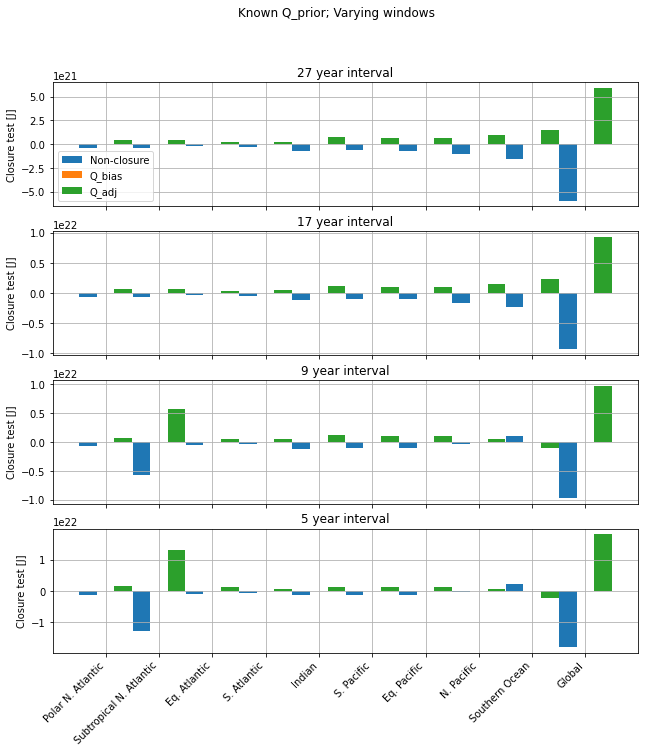

In [78]:

labels = np.append(CT_early.Basin.values, 'Global')
years = [27,17,9,5]
x = np.arange(len(labels))+0.5  # the label locations
width = 0.33  # the width of the bars

fig, axs = plt.subplots(4,1, figsize=(15*0.7,15*0.7), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel()
for i in range(dyrs.size):

    axs[i].bar(x-width, np.append((basin_scale_nonclosure_HF)[i,:], np.nansum(basin_scale_nonclosure_HF, axis=-1)[i]), width, label = 'Non-closure')
    axs[i].bar(x, np.append(basin_scale_Q_bias[i,:], np.nansum(basin_scale_Q_bias, axis=-1)[i]), width, label = 'Q_bias')
    axs[i].bar(x+width, np.append(basin_scale_Q_adj[i,:], np.nansum(basin_scale_Q_adj, axis=-1)[i]), width, label = 'Q_adj')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels([])
    axs[i].grid()
    axs[i].set_title(str(years[i])+' year interval')
    axs[i].set_ylabel('Closure test [J]')
axs[-1].set_xticklabels(labels, rotation=45, ha='right')

plt.suptitle('Known Q_prior; Varying windows')
axs[0].legend(loc=3)
plt.savefig('../Figures/ACCESS_varying_windows_known_Q_prior_bars_closure.png', dpi=300, bbox_inches='tight')
plt.show()
    



In [125]:

data_ACCESS_wfo = xr.open_mfdataset('~/UNSW_Work/ACCESS_CM2/wfo_ACCESS_hist_proper.nc') ## hfds: Wm^-2; wfo: kgm^-2s^-1
data_ACCESS_hfds = xr.open_mfdataset('~/UNSW_Work/ACCESS_CM2/hfds_ACCESS_hist_proper.nc') ## hfds: Wm^-2; wfo: kgm^-2s^-1
ACCESS_dArea = xr.open_mfdataset('~/UNSW_Work/ACCESS_CM2/darea_ACCESS_hist_proper.nc').sel(time=slice('1979-01-01',None)).mean('time')
ACCESS_dArea_masked = data_ACCESS_hfds.__xarray_dataarray_variable__.isel(time=0)/data_ACCESS_hfds.__xarray_dataarray_variable__.isel(time=0)*ACCESS_dArea.area_t

data_ACCESS_dtime = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/dtime*.nc')

## Calculate the cumulative time integrated surface fluxes 
hfds_ACCESS_cumsum = ((data_ACCESS_hfds.__xarray_dataarray_variable__*data_ACCESS_dtime.average_DT).cumsum('time').isel(time=Late_period[-1])\
    -(data_ACCESS_hfds.__xarray_dataarray_variable__*data_ACCESS_dtime.average_DT).cumsum('time').isel(time=Early_period[0])) # UNITS: [J/m2]
wfo_ACCESS_cumsum = ((data_ACCESS_wfo.pme_river*data_ACCESS_dtime.average_DT).cumsum('time').isel(time=Late_period[-1])\
    -(data_ACCESS_wfo.pme_river*data_ACCESS_dtime.average_DT).cumsum('time').isel(time=Early_period[0])) # UNITS: [kg/m2]

hfds_ACCESS = hfds_ACCESS_cumsum*int_scaling*(1/(range_yrs*yr2sec)) # UNITS: [W/m2]
hfds_ACCESS_J = hfds_ACCESS_cumsum*int_scaling*ACCESS_dArea_masked # UNITS: [J]
wfo_ACCESS_kg_m2_s = wfo_ACCESS_cumsum*int_scaling*(1/(range_yrs*yr2sec)) # UNITS: [kg/m2/s]
wfo_ACCESS_m3 = wfo_ACCESS_cumsum*int_scaling*ACCESS_dArea_masked/rho
wfo_ACCESS = wfo_ACCESS_kg_m2_s/(rho)*24*3600*1000 # UNITS: mm/day

hfds_ACCESS_J.load()
hfds_ACCESS.load()
wfo_ACCESS_m3.load()
wfo_ACCESS.load()

<xarray.DataArray (yt_ocean: 300, xt_ocean: 360)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    geolat_t  (yt_ocean, xt_ocean) float32 -77.88 -77.88 -77.88 ... 65.63 65.21
    geolon_t  (yt_ocean, xt_ocean) float32 -279.5 -278.5 -277.5 ... 79.97 79.99